# Predicting the price of Bitcoin, intro to LSTM


In [111]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns

## Data Exploration

In [112]:
data = pd.read_csv("data/bitcoin.csv")
data = data.sort_values('Date')
data.head()

,Date,Symbol,Open,High,Low,Close,Volume BTC,Volume USD
2000,2014-12-01,BTCUSD,300.0,370.0,300.00,370.0,0.05656,19.53
1999,2014-12-02,BTCUSD,370.0,378.0,370.00,378.0,15.01000,5675.07
1998,2014-12-03,BTCUSD,378.0,378.0,377.01,378.0,0.54660,206.52
1997,2014-12-04,BTCUSD,378.0,378.0,377.10,377.1,0.01000,3.77
1996,2014-12-05,BTCUSD,377.1,377.1,377.10,377.1,0.00000,0.00


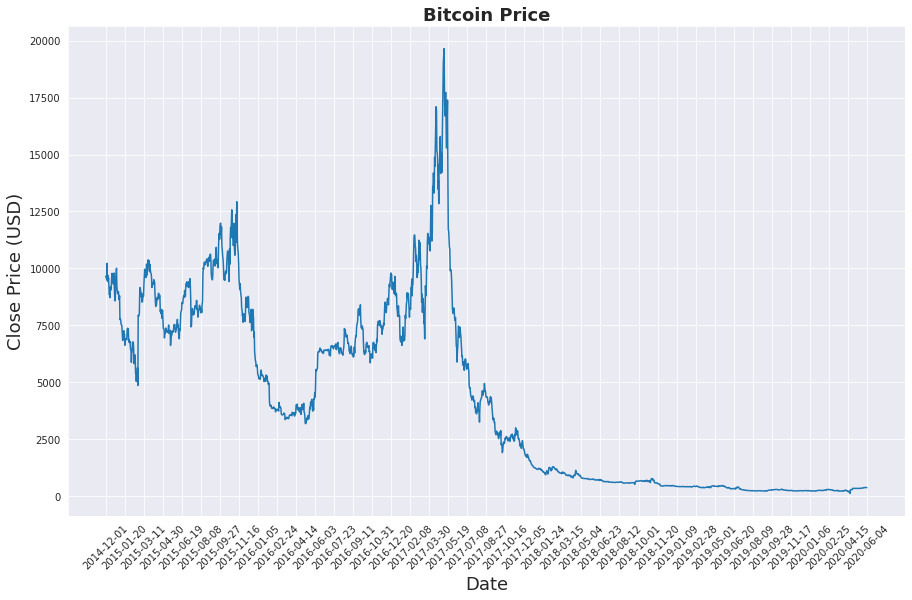

In [113]:
price = data[['Close']]

plt.figure(figsize = (15,9))
plt.plot(price)
plt.xticks(range(0, data.shape[0],50), data['Date'].loc[::50],rotation=45)
plt.title("Bitcoin Price",fontsize=18, fontweight='bold')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.show()

In [114]:
price.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2001 entries, 2000 to 0
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2001 non-null   float64
dtypes: float64(1)
memory usage: 31.3 KB


## Data Preparation

### Normalization

In [115]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()

norm_data = min_max_scaler.fit_transform(price.values)

In [124]:
print(f'Real: {price.values[0]}, Normalized: {norm_data[0]}')
print(f'Real: {price.values[500]}, Normalized: {norm_data[500]}')
print(f'Real: {price.values[1200]}, Normalized: {norm_data[1200]}')

Real: [370.], Normalized: [0.01280082]
Real: [426.1], Normalized: [0.01567332]
Real: [8259.99], Normalized: [0.41679416]


### Data split

In [116]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

past_history = 5
future_target = 0

TRAIN_SPLIT = int(len(norm_data) * 0.8)


x_train, y_train = univariate_data(norm_data,
                                   0,
                                   TRAIN_SPLIT,
                                   past_history,
                                   future_target)

x_test, y_test = univariate_data(norm_data,
                                 TRAIN_SPLIT,
                                 None,
                                 past_history,
                                 future_target)

## Build the model

In [117]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, LSTM, LeakyReLU, Dropout

num_units = 64
learning_rate = 0.0001
activation_function = 'sigmoid'
adam = Adam(lr=learning_rate)
loss_function = 'mse'
batch_size = 5
num_epochs = 50

# Initialize the RNN
model = Sequential()
model.add(LSTM(units = num_units, activation=activation_function, input_shape=(None, 1)))
model.add(LeakyReLU(alpha=0.5))
model.add(Dropout(0.1))
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer=adam, loss=loss_function)

In [118]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 64)                16896     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


## Train the model

In [119]:
# Using the training set to train the model
history = model.fit(
    x_train,
    y_train,
    validation_split=0.1,
    batch_size=batch_size,
    epochs=num_epochs,
    shuffle=False
)

Train on 1435 samples, validate on 160 samples
Epoch 1/50
1435/1435 [==============================] - 1s 618us/step - loss: 0.0348 - val_loss: 0.0146
Epoch 2/50
1435/1435 [==============================] - 1s 374us/s

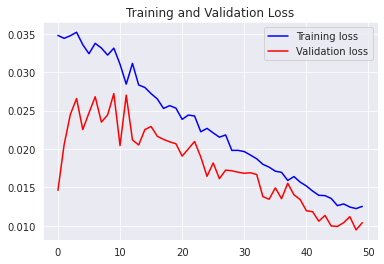

In [120]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title("Training and Validation Loss")
plt.legend()

plt.show()

## Prediction
For each of the items we used for the validation, let's now predict them so we can compare how well we did.

[]

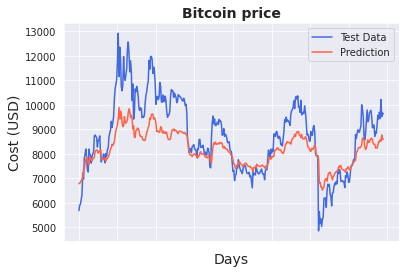

In [121]:
original = pd.DataFrame(min_max_scaler.inverse_transform(y_test))
predictions = pd.DataFrame(min_max_scaler.inverse_transform(model.predict(x_test)))

ax = sns.lineplot(x=original.index, y=original[0], label="Test Data", color='royalblue')
ax = sns.lineplot(x=predictions.index, y=predictions[0], label="Prediction", color='tomato')
ax.set_title('Bitcoin price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)